In [5]:
# Import necessary libraries
import tensorflow as tf
from keras import layers, models
from keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from datetime import datetime
import numpy as np
import random
import shutil

In [6]:
# Set my Sudent ID as random seed
STUDENT_ID = 409920 

# Set random seeds for reproducibility
tf.random.set_seed(STUDENT_ID)
np.random.seed(STUDENT_ID)

# Dataset parameters
IMG_SIZE_SMALL = 128  # Size for basic CNNs (Baseline, Deep Reg, Grayscale)
IMG_SIZE_VGG = 224    # Size required for VGG16
IMG_SIZE_SQUEEZE = 227  # Size for SqueezeNet
BATCH_SIZE = 32

# Define paths
dataset_path = 'dataset'

# Number of classes in the dataset
NUM_CLASSES = 3  # rock, paper, scissors

print("TensorFlow version:", tf.__version__)
print("Setup complete with student ID", STUDENT_ID, "as random seed")

TensorFlow version: 2.19.0
Setup complete with student ID 409920 as random seed


Total images in dataset: 2925

Split        Paper      Rock       Scissors   Total       
------------------------------------------------------------
train        683        683        683        2049         (70.1%)
validation   97         97         97         291          (9.9%)
test         195        195        195        585          (20.0%)


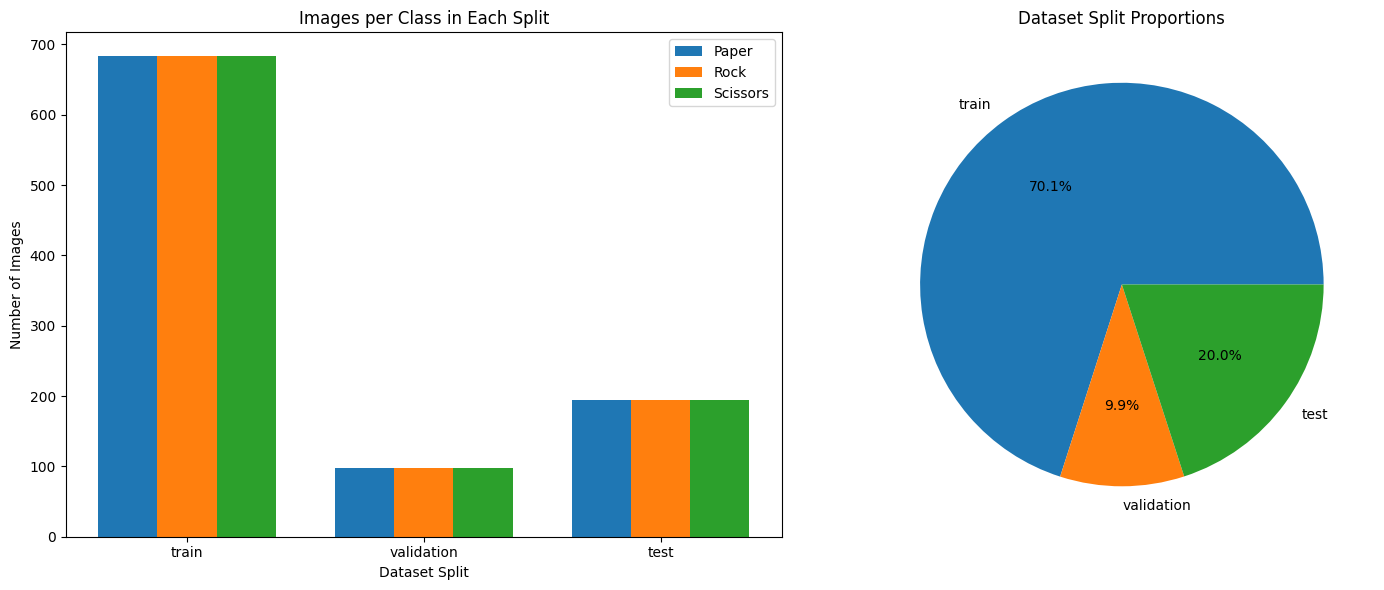


CLASS BALANCE WITHIN EACH SPLIT:
------------------------------------------------------------
TRAIN:
  Paper:    683 images (33.3%)
  Rock:     683 images (33.3%)
  Scissors: 683 images (33.3%)

VALIDATION:
  Paper:    97 images (33.3%)
  Rock:     97 images (33.3%)
  Scissors: 97 images (33.3%)

TEST:
  Paper:    195 images (33.3%)
  Rock:     195 images (33.3%)
  Scissors: 195 images (33.3%)



In [7]:
# Function to count images in a directory and its subdirectories
def count_images_in_directory(directory):
    class_counts = {}
    total_count = 0
    
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist!")
        return class_counts, total_count
    
    # Get all subdirectories (classes)
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
    # If there are no subdirectories, count images directly in the directory
    if not class_dirs:
        image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        return {"no_class": len(image_files)}, len(image_files)
    
    # Count images in each class
    for class_name in class_dirs:
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        count = len(image_files)
        class_counts[class_name] = count
        total_count += count
    
    return class_counts, total_count

# Get counts for each split
dataset_root = 'dataset'
splits = ['train', 'validation', 'test']
all_counts = {}
total_images = 0

for split in splits:
    split_path = os.path.join(dataset_root, split)
    class_counts, split_total = count_images_in_directory(split_path)
    all_counts[split] = {
        'class_counts': class_counts,
        'total': split_total
    }
    total_images += split_total

# Print results in a formatted way
print(f"Total images in dataset: {total_images}\n")
print("{:<12} {:<10} {:<10} {:<10} {:<12}".format("Split", "Paper", "Rock", "Scissors", "Total"))
print("-" * 60)

for split in splits:
    counts = all_counts[split]['class_counts']
    split_total = all_counts[split]['total']
    
    # Get counts for each class (or 0 if class not present)
    paper_count = counts.get('paper', 0)
    rock_count = counts.get('rock', 0)
    scissors_count = counts.get('scissors', 0)
    
    # Calculate percentages of total dataset
    split_percent = (split_total / total_images) * 100
    
    print("{:<12} {:<10} {:<10} {:<10} {:<12} ({:.1f}%)".format(
        split, paper_count, rock_count, scissors_count, split_total, split_percent
    ))

# Create visualizations
plt.figure(figsize=(15, 6))

# Plot 1: Images per class in each split
plt.subplot(1, 2, 1)
width = 0.25
x = np.arange(len(splits))

# Extract counts for plotting
paper_counts = [all_counts[split]['class_counts'].get('paper', 0) for split in splits]
rock_counts = [all_counts[split]['class_counts'].get('rock', 0) for split in splits]
scissors_counts = [all_counts[split]['class_counts'].get('scissors', 0) for split in splits]

plt.bar(x - width, paper_counts, width, label='Paper')
plt.bar(x, rock_counts, width, label='Rock')
plt.bar(x + width, scissors_counts, width, label='Scissors')

plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.title('Images per Class in Each Split')
plt.xticks(x, splits)
plt.legend()

# Plot 2: Split proportions
plt.subplot(1, 2, 2)
split_totals = [all_counts[split]['total'] for split in splits]
plt.pie(split_totals, labels=splits, autopct='%1.1f%%')
plt.title('Dataset Split Proportions')

plt.tight_layout()
plt.show()

print("\nCLASS BALANCE WITHIN EACH SPLIT:")
print("-" * 60)
for split in splits:
    counts = all_counts[split]['class_counts']
    split_total = all_counts[split]['total']
    
    # Get counts for each class (or 0 if class not present)
    paper_count = counts.get('paper', 0)
    rock_count = counts.get('rock', 0)
    scissors_count = counts.get('scissors', 0)
    
    # Calculate percentages within the split
    paper_percent = (paper_count / split_total) * 100 if split_total > 0 else 0
    rock_percent = (rock_count / split_total) * 100 if split_total > 0 else 0
    scissors_percent = (scissors_count / split_total) * 100 if split_total > 0 else 0
    
    print(f"{split.upper()}:")
    print(f"  Paper:    {paper_count} images ({paper_percent:.1f}%)")
    print(f"  Rock:     {rock_count} images ({rock_percent:.1f}%)")
    print(f"  Scissors: {scissors_count} images ({scissors_percent:.1f}%)")
    print()

In [8]:
# Set to False to prevent rebalancing
PERFORM_REBALANCING = False

# Set random seed for reproducibility
random.seed(STUDENT_ID)

def rebalance_dataset(dataset_path, source_split='train', target_splits=None, 
                      classes=['paper', 'rock', 'scissors']):
    """
    Rebalance the dataset by moving images from source_split to target_splits.
    
    Args:
        dataset_path: Path to the dataset root folder
        source_split: Folder to take images from (e.g., 'train')
        target_splits: Dictionary mapping target split names to images per class to move
        classes: List of class folders
    """
    if target_splits is None:
        return
    
    for class_name in classes:
        # Define source directory
        source_dir = os.path.join(dataset_path, source_split, class_name)
        
        # Get all image files in source directory
        image_files = [f for f in os.listdir(source_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Keep track of which images have been moved
        moved_images = []
        
        # Process each target split
        for target_split, images_per_class in target_splits.items():
            # Define target directory
            target_dir = os.path.join(dataset_path, target_split, class_name)
            
            # Create target directory if it doesn't exist
            os.makedirs(target_dir, exist_ok=True)
            
            # Get remaining images that haven't been moved yet
            remaining_images = [img for img in image_files if img not in moved_images]
            
            # Check if we have enough images to move
            if len(remaining_images) < images_per_class:
                print(f"Warning: Not enough images in {source_dir}. Found {len(remaining_images)}, need {images_per_class}")
                continue
                
            # Randomly select images to move
            images_to_move = random.sample(remaining_images, images_per_class)
            moved_images.extend(images_to_move)
            
            # Move selected images to target directory
            for image in images_to_move:
                source_file = os.path.join(source_dir, image)
                target_file = os.path.join(target_dir, image)
                shutil.move(source_file, target_file)
                print(f"Moved: {image} from {source_split}/{class_name} to {target_split}/{class_name}")
        
        total_moved = len(moved_images)
        print(f"Moved a total of {total_moved} images from {source_split}/{class_name}")

# Calculate proper amounts to move to achieve approximately 70/10/20 split
def calculate_moves_for_target_split(total_images=2925, current_splits=None):
    """
    Calculate how many images to move from train to validation and test
    to achieve approximately 70/10/20 split.
    """
    if current_splits is None:
        # Use your current distribution
        current_splits = {
            'train': 2520,
            'validation': 33,
            'test': 372
        }
    
    # Target numbers (based on 70/10/20 of total)
    target_train = int(total_images * 0.7)
    target_validation = int(total_images * 0.1)
    target_test = int(total_images * 0.2)
    
    # Calculate how many images to move from train
    to_validation = target_validation - current_splits['validation']
    to_test = target_test - current_splits['test']
    
    # Calculate per class (assuming 3 classes)
    to_validation_per_class = to_validation // 3
    to_test_per_class = to_test // 3
    
    print(f"To achieve 70/10/20 split:")
    print(f"  Move {to_validation_per_class} images per class from train to validation")
    print(f"  Move {to_test_per_class} images per class from train to test")
    
    return {
        'validation': to_validation_per_class,
        'test': to_test_per_class
    }

# Verify the distribution
def count_images(directory):
    """Count the number of images in each class directory."""
    class_counts = {}
    
    # Check if directory exists
    if not os.path.exists(directory):
        return class_counts
    
    # Get all subdirectories (classes)
    class_dirs = [d for d in os.listdir(directory) 
                  if os.path.isdir(os.path.join(directory, d))]
    
    # Count images in each class
    for class_name in class_dirs:
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)
    
    return class_counts

# Count current distribution
dataset_path = 'dataset'

if PERFORM_REBALANCING:
    # This block contains the actual rebalancing code
    current_distribution = {}
    total_images = 0

    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        split_total = sum(counts.values())
        current_distribution[split] = split_total
        total_images += split_total

    print("\nCURRENT DATASET DISTRIBUTION:")
    for split, count in current_distribution.items():
        print(f"  {split.capitalize()}: {count} images ({count/total_images*100:.1f}%)")

    # Calculate how many images to move
    moves = calculate_moves_for_target_split(total_images, current_distribution)

    # Run the rebalancing
    print("\nRebalancing dataset...")
    rebalance_dataset(dataset_path, 'train', moves)

    # Display the new counts
    print("\nNEW DATASET DISTRIBUTION:")
    new_distribution = {}
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        split_total = sum(counts.values())
        new_distribution[split] = split_total
        print(f"  {split.capitalize()} SET:")
        for class_name, count in counts.items():
            print(f"    {class_name}: {count} images")
        print(f"    Total: {split_total} images ({split_total/total_images*100:.1f}%)")

    print("\nRebalancing complete!")
else:
    # This block just shows information about the previous rebalancing
    print("REBALANCING SKIPPED - Dataset was previously rebalanced")
    print("To run rebalancing again, set PERFORM_REBALANCING = True (not recommended)")
    
    # Instead of rebalancing, just display the current distribution
    current_distribution = {}
    total_images = 0

    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        split_total = sum(counts.values())
        current_distribution[split] = split_total
        total_images += split_total

    print("\nCURRENT DATASET DISTRIBUTION:")
    for split, count in current_distribution.items():
        print(f"  {split.capitalize()}: {count} images ({count/total_images*100:.1f}%)")
    
    print("\nClass distribution within each split:")
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        print(f"  {split.capitalize()} SET:")
        for class_name, count in sorted(counts.items()):
            print(f"    {class_name}: {count} images")

REBALANCING SKIPPED - Dataset was previously rebalanced
To run rebalancing again, set PERFORM_REBALANCING = True (not recommended)

CURRENT DATASET DISTRIBUTION:
  Train: 2049 images (70.1%)
  Validation: 291 images (9.9%)
  Test: 585 images (20.0%)

Class distribution within each split:
  Train SET:
    paper: 683 images
    rock: 683 images
    scissors: 683 images
  Validation SET:
    paper: 97 images
    rock: 97 images
    scissors: 97 images
  Test SET:
    paper: 195 images
    rock: 195 images
    scissors: 195 images


In [ ]:
def load_dataset(split_path, img_size, grayscale=False, batch_size=BATCH_SIZE, augment=False):
    """
    Load and prepare a dataset with given parameters.
    
    Args:
        split_path: Path to dataset split folder (train, validation, or test)
        img_size: Target image size (height and width)
        grayscale: If True, convert images to grayscale
        batch_size: Number of images per batch
        augment: If True, apply data augmentation (for training only)
        
    Returns:
        Preprocessed TensorFlow dataset
    """
    # Load dataset from directory structure
    dataset = tf.keras.utils.image_dataset_from_directory(
        split_path,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        seed=STUDENT_ID  # Using student ID as seed for reproducibility
    )
    
    # Store class names before applying transformations
    class_names = dataset.class_names
    
    # Define preprocessing operations
    preprocessing_layers = []
    
    # Normalization layer (scale pixel values to 0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    
    # Convert to grayscale if specified
    if grayscale:
        dataset = dataset.map(
            lambda x, y: (tf.image.rgb_to_grayscale(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Apply normalization
    dataset = dataset.map(
        lambda x, y: (normalization_layer(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply data augmentation if specified (only for training)
    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1)
        ])
        
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Optimize pipeline with prefetching
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset, class_names

In [10]:
# Function to visualize sample images from a dataset
def visualize_dataset_samples(dataset, class_names, title, grayscale=False, samples=9):
    """
    Visualize sample images from a dataset
    
    Args:
        dataset: TensorFlow dataset to visualize
        class_names: List of class names
        title: Plot title
        grayscale: If True, visualize as grayscale images
        samples: Number of samples to visualize
    """
    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=16)
    
    # Get a batch of images from the dataset
    for images, labels in dataset.take(1):
        # Plot each image
        for i in range(min(samples, len(images))):
            plt.subplot(3, 3, i + 1)
            
            # Display image based on color mode
            if grayscale:
                plt.imshow(images[i, :, :, 0], cmap='gray')
            else:
                plt.imshow(images[i].numpy().astype("uint8"))
                
            plt.title(class_names[labels[i]])
            plt.axis("off")
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

print("Dataset loading and visualization functions defined")

Dataset loading and visualization functions defined


In [11]:
# Load RGB datasets for Baseline and Deep Regularized CNN (128x128)
print("Loading RGB datasets (128x128)...")

# Training set with augmentation 
train_ds_small_rgb = load_dataset(
    os.path.join(dataset_path, 'train'), 
    IMG_SIZE_SMALL, 
    grayscale=False, 
    augment=True
)

# Validation set (no augmentation)
val_ds_small_rgb = load_dataset(
    os.path.join(dataset_path, 'validation'), 
    IMG_SIZE_SMALL, 
    grayscale=False
)

# Test set (no augmentation)
test_ds_small_rgb = load_dataset(
    os.path.join(dataset_path, 'test'), 
    IMG_SIZE_SMALL, 
    grayscale=False
)

# Get class names from the dataset
class_names = train_ds_small_rgb.class_names
print(f"Classes detected: {class_names}")

# Get the shape of the images and labels in the dataset
for images, labels in train_ds_small_rgb.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image data type: {images.dtype}")
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")
    print(f"First few labels: {labels[:5].numpy()}")

# Count number of batches in each dataset
print(f"Training dataset: {len(list(train_ds_small_rgb))} batches")
print(f"Validation dataset: {len(list(val_ds_small_rgb))} batches")
print(f"Test dataset: {len(list(test_ds_small_rgb))} batches")

# Estimate total number of images
train_images = len(list(train_ds_small_rgb)) * BATCH_SIZE
val_images = len(list(val_ds_small_rgb)) * BATCH_SIZE
test_images = len(list(test_ds_small_rgb)) * BATCH_SIZE
print(f"Approximate number of images:")
print(f"  Training: ~{train_images} images")
print(f"  Validation: ~{val_images} images")
print(f"  Test: ~{test_images} images")

# Visualize sample training images
visualize_dataset_samples(
    train_ds_small_rgb, 
    class_names, 
    title="RGB Training Images (128×128)"
)

# Visualize sample augmented images
# Run this cell multiple times to see different augmentations
plt.figure(figsize=(10, 10))
plt.suptitle("Data Augmentation Examples (128×128)", fontsize=16)

for images, labels in train_ds_small_rgb.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print("RGB dataset loading verified successfully!")

Loading RGB datasets (128x128)...
Found 2049 files belonging to 3 classes.
Found 291 files belonging to 3 classes.
Found 585 files belonging to 3 classes.


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'